In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score
from IPython.display import Audio, display
import os
import json
import torch
import librosa
import warnings
from scipy.stats import entropy
from matplotlib.colors import LogNorm
import matplotlib
import copy
warnings.filterwarnings("ignore")
%matplotlib inline
import sys
sys.path.append('../cdsd')
from data import CDSDDataset, get_data_transforms, SAMPLE_RATE
from models import construct_separator, construct_classifier
from scipy.stats import gaussian_kde

In [2]:
models_dir = '/scratch/jtc440/cdsd/models'

In [3]:
ls /scratch/jtc440/cdsd/models/

orig/
pishdadian2020-background2017_crnn_classifier_clip_lr1en4/
pishdadian2020-background2017_crnn_classifier_frame_lr1en4/
pishdadian2020-background2017n0dB_crnn_classifier_clip_lr1en4/
pishdadian2020-background2017n0dB_crnn_classifier_frame_lr1en4/
pishdadian2020-background2017n0dB_rnn_separator_crnn_classifier_clip_frozen_lr1en4/
pishdadian2020-background2017n0dB_rnn_separator_crnn_classifier_clip_frozen_lr1en4_margin5en4/
pishdadian2020-background2017n0dB_rnn_separator_crnn_classifier_frame_frozen_lr1en4/
pishdadian2020-background2017n0dB_rnn_separator_crnn_classifier_frame_frozen_lr1en4_margin5en4/
pishdadian2020-background2017n0dB_rnn_separator_supervised_lr1en4/
pishdadian2020-background2017n10dB_crnn_classifier_clip_lr1en4/
pishdadian2020-background2017n10dB_crnn_classifier_frame_lr1en4/
pishdadian2020-background2017n10dB_rnn_separator_crnn_classifier_clip_frozen_lr1en4/
pishdadian2020-background2017n10dB_rnn_separator_crnn_classifier_clip_frozen_lr1en4_margin5en4/
pishdadian2

In [4]:
classifier_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_crnn_classifier_frame_lr1en4'
separator_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_frame_frozen_lr1en4'

In [57]:
classifier_train_history = os.path.join(classifier_dir, "history.csv")
separator_train_history = os.path.join(separator_dir, "history.csv")

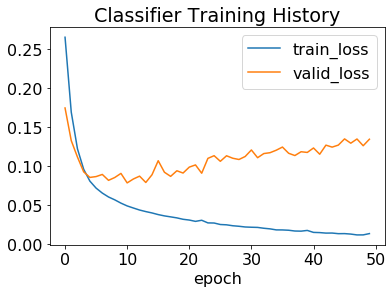

In [58]:
classifier_history = pd.read_csv(classifier_train_history)
classifier_history.plot(x='epoch', title='Classifier Training History')

In [30]:
separator_history = pd.read_csv(separator_train_history)
if 'supervised' in os.path.splitext(separator_dir)[0]:
    separator_history.plot(x='epoch', y=['train_loss', 'valid_loss'], title='Separator Training History')
else:
    separator_history.plot(x='epoch', y=['train_tot_loss', 'valid_tot_loss'], title='Separator Training History')

KeyError: "None of [Index(['train_loss', 'valid_loss'], dtype='object')] are in the [columns]"

In [3]:
model_names = [
    "pishdadian2020_rnn_separator_crnn_classifier_clip_frozen_lr1en4",
    "pishdadian2020_rnn_separator_crnn_classifier_frame_frozen_lr1en4",
    "pishdadian2020_rnn_separator_supervised_lr1en4",
]

In [5]:
model_names = [
    "pishdadian2020-nobackground_rnn_separator_supervised_lr1en4",
    "pishdadian2020-background2017_rnn_separator_supervised_lr1en4",
    "pishdadian2020-nobackground_rnn_separator_crnn_classifier_clip_frozen_lr1en4",
    "pishdadian2020-background2017_rnn_separator_crnn_classifier_clip_frozen_lr1en4",
    "pishdadian2020-background2017_rnn_separator_crnn_classifier_clip_frozen_lr1en4_margin5en4",
    "pishdadian2020-nobackground_rnn_separator_crnn_classifier_frame_frozen_lr1en4", 
    "pishdadian2020-background2017_rnn_separator_crnn_classifier_frame_frozen_lr1en4",
    "pishdadian2020-background2017_rnn_separator_crnn_classifier_frame_frozen_lr1en4_margin5en4",
]

In [5]:
model_names = sorted([x for x in os.listdir(models_dir) if ("nobackground" in x or "background2017n" in x) and ("separator" in x)], reverse=True)

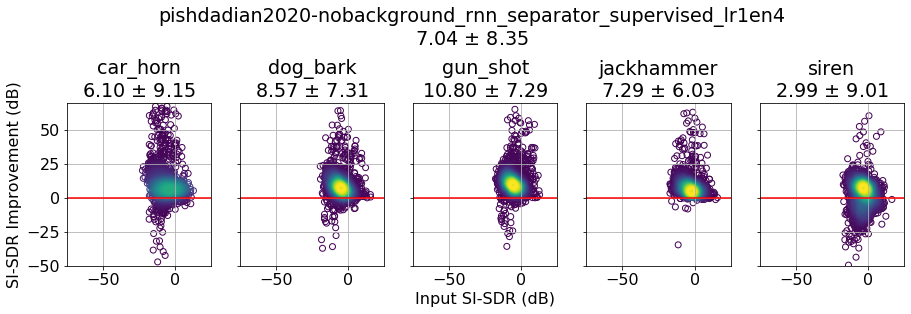

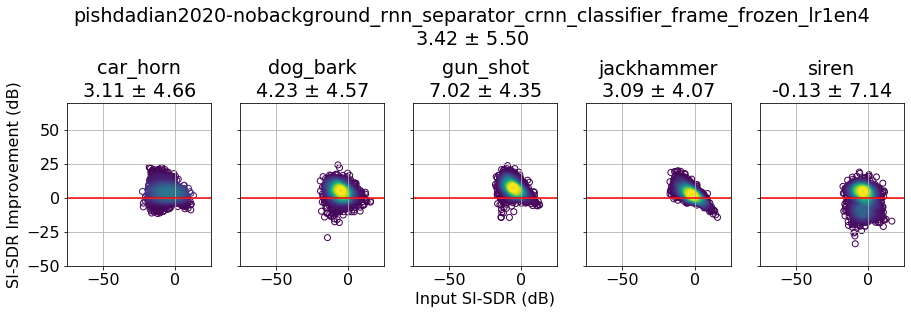

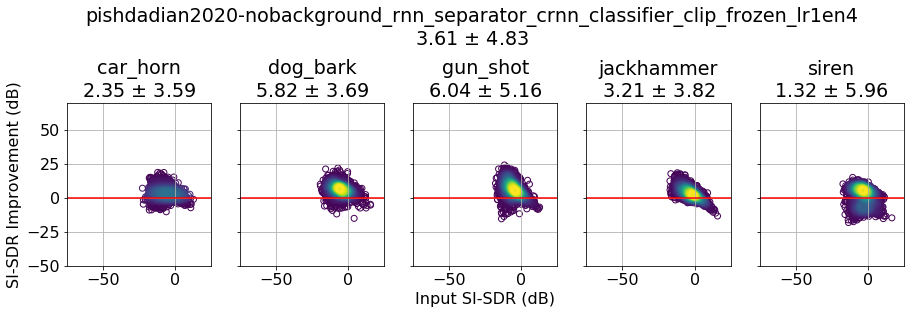

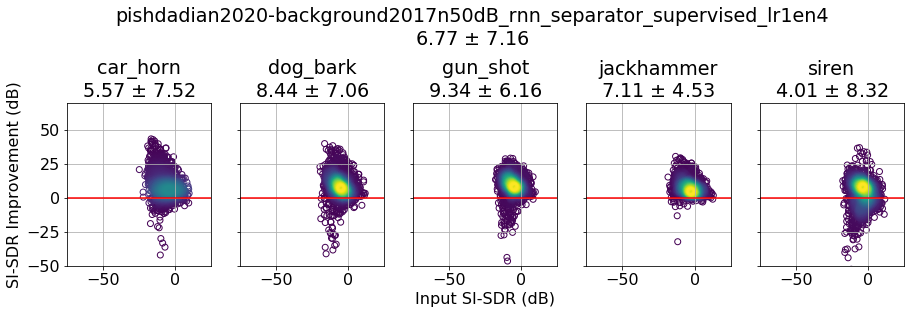

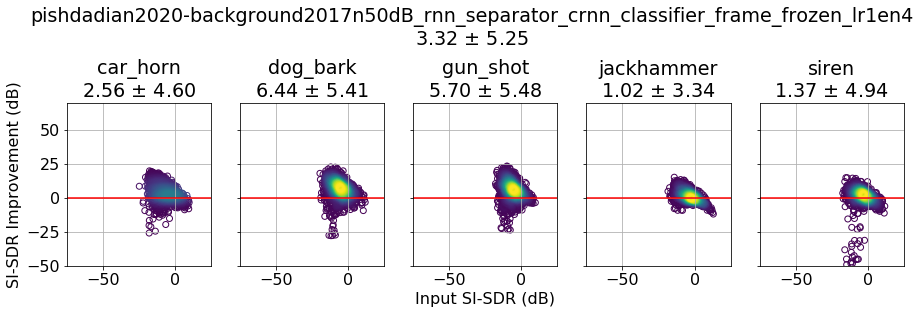

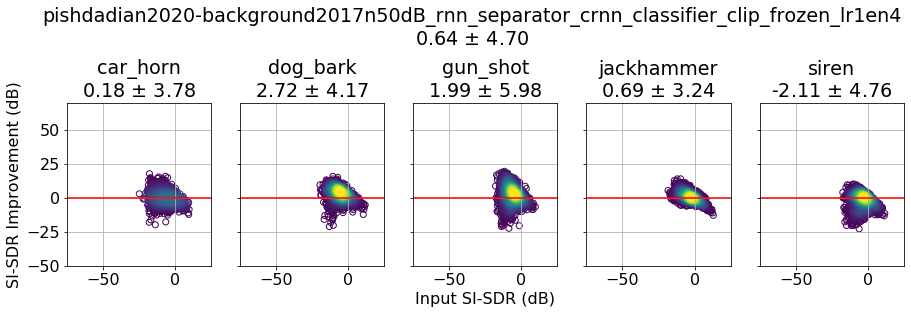

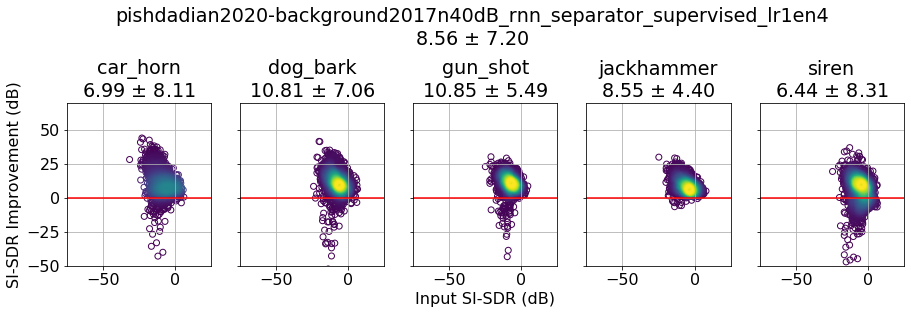

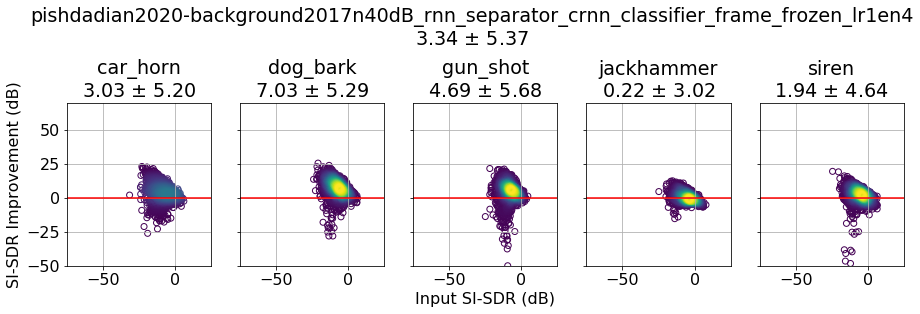

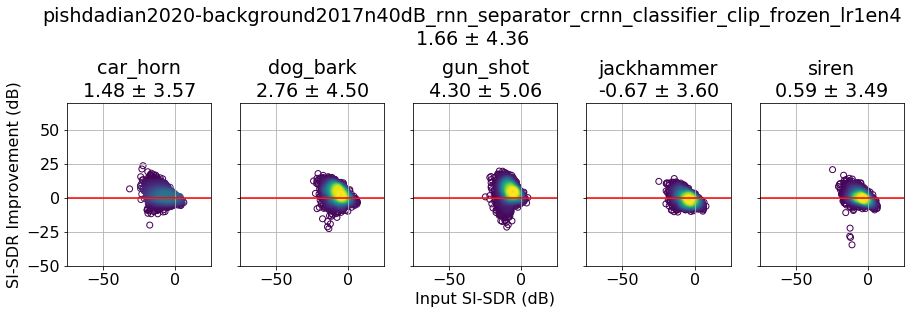

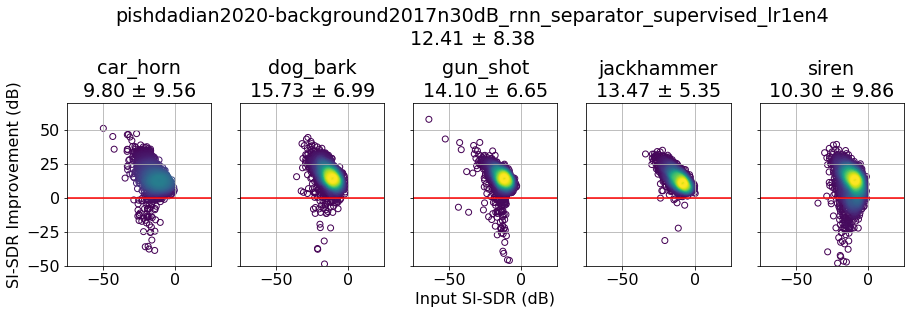

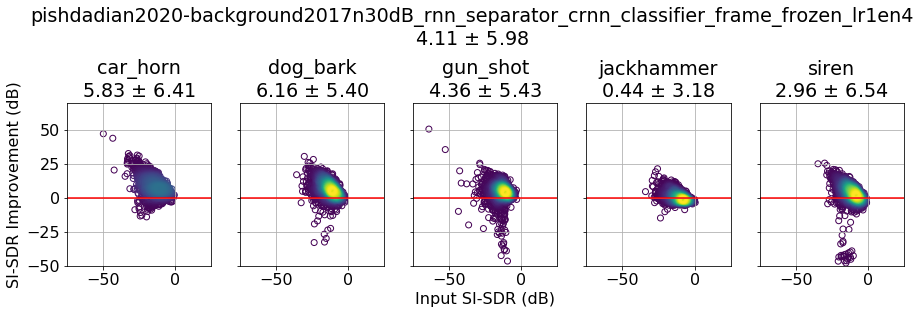

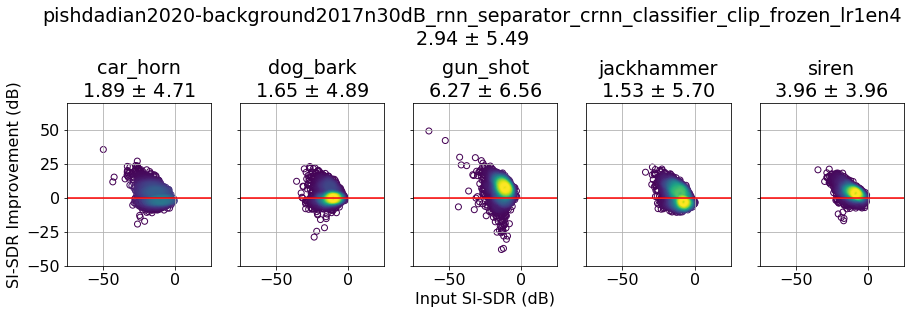

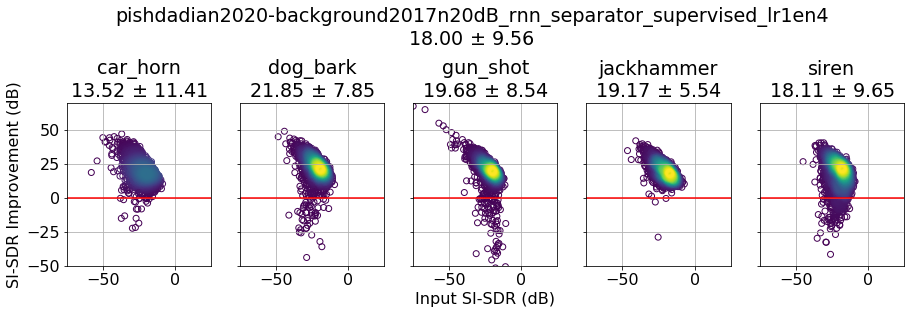

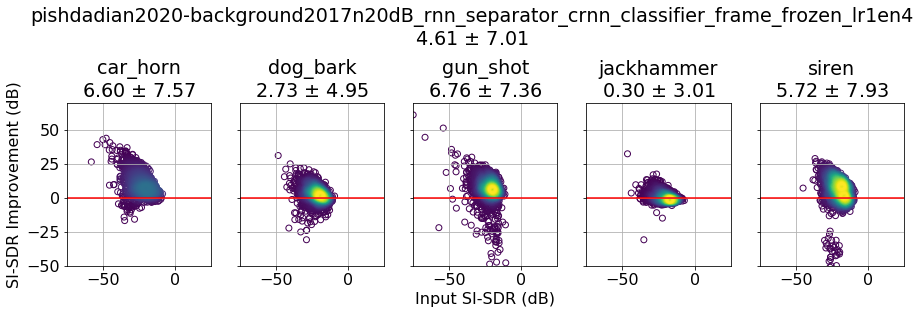

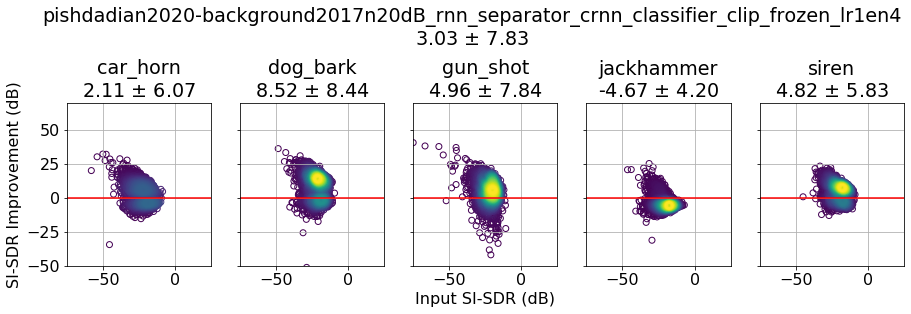

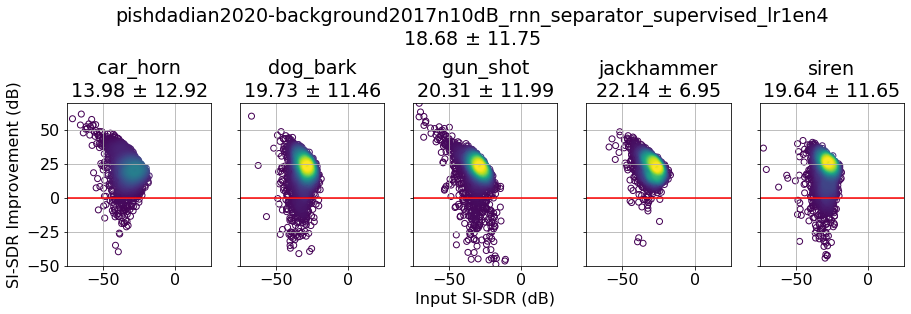

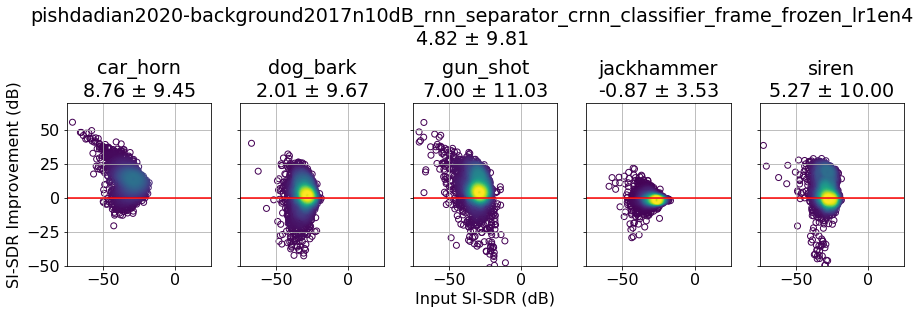

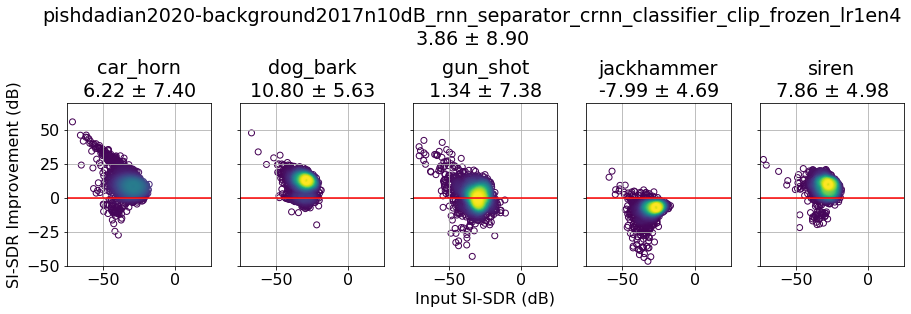

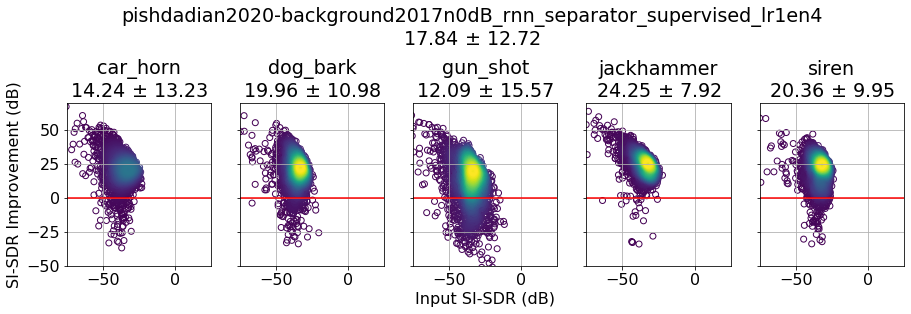

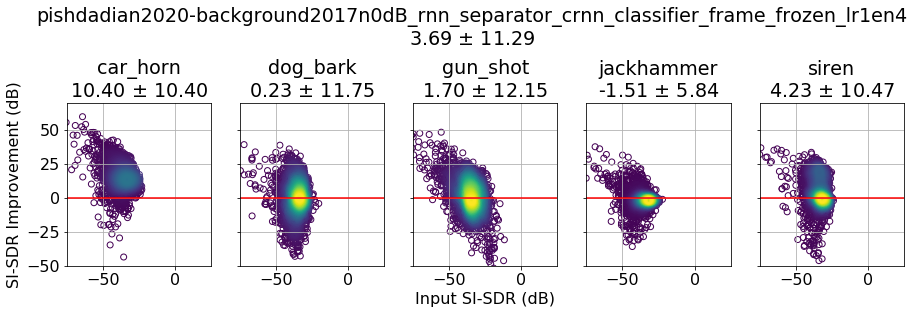

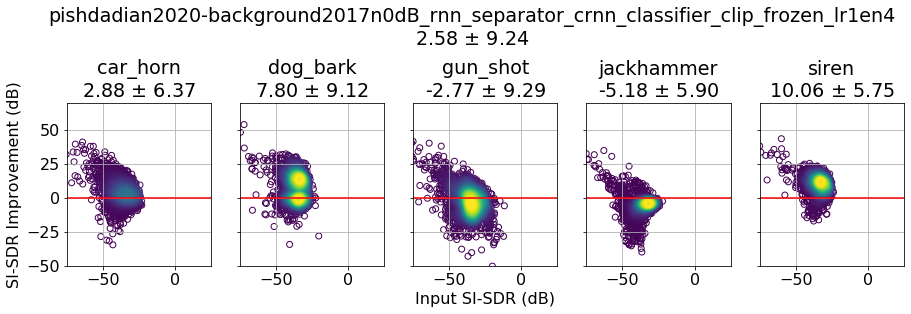

In [29]:
for exp_name in model_names:
    separator_dir = os.path.join(models_dir, exp_name)
    sep_config_path = os.path.join(separator_dir, 'config.json')
    if 'supervised' in exp_name:
        sep_res_path = os.path.join(separator_dir, 'fully_supervised_separation_results_earlystopping_test.csv')
    else:
        sep_res_path = os.path.join(separator_dir, 'separation_results_earlystopping_test.csv')

    if not os.path.exists(sep_config_path):
        continue
        
    if "margin" in exp_name:
        continue
        
    if not os.path.exists(sep_res_path):
        print("Missing: {}".format(sep_res_path))
        continue
        
    with open(sep_config_path, 'r') as f:
        sep_config = json.load(f)
        
    #if 'merl' not in sep_config['root_data_dir']:
    #    continue

    #label_mode = sep_config['training']['label_mode']
    sep_df = pd.read_csv(sep_res_path)
    labels = [x.replace('_input_sisdr', '') for x in sep_df.keys() if x.endswith('_input_sisdr')]
    num_labels = len(labels)

    fig, axes = plt.subplots(ncols=len(labels), figsize=(15, 3), sharey=True)
    plt.rcParams.update({'font.size': 16})

    total_sisdr_arr = []
    label_sisdr = []
    
    num_sources = None
    for idx, label in enumerate(labels):
        if num_sources is None:
            num_sources = sep_df[label + '_presence_gt'].to_numpy()
        else:
            num_sources += sep_df[label + '_presence_gt'].to_numpy()
    multi_source_mask = (num_sources > 1).astype(bool)

    for idx, label in enumerate(labels):
        mask = sep_df[label + '_presence_gt'].to_numpy().astype(bool)
        mask = np.logical_and(mask, multi_source_mask)
        input_sisdr = sep_df[label + '_input_sisdr'].to_numpy()[mask]
        impro_sisdr = np.nan_to_num(sep_df[label + '_sisdr_improvement'].to_numpy())[mask]

        ax = axes[idx]
        ax.set_title("{}\n{:.2f} $\pm$ {:.2f}".format(label, np.mean(impro_sisdr), np.std(impro_sisdr)))
        if idx == 0:
            ax.set_ylabel('SI-SDR Improvement (dB)')
        if idx == (len(labels) // 2):
            ax.set_xlabel('Input SI-SDR (dB)')
            
        xy = np.vstack([input_sisdr, impro_sisdr])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        sorted_idxs = z.argsort()
        input_sisdr, impro_sisdr, z = input_sisdr[sorted_idxs], impro_sisdr[sorted_idxs], z[sorted_idxs]
        norm = Normalize(vmin=z.min(), vmax=z.max())
        my_cmap = matplotlib.cm.get_cmap()
        color_list = [my_cmap(norm(c)) for c in z]
        
        ax.scatter(input_sisdr, impro_sisdr, edgecolors=color_list, facecolors='none')
        ax.set_ylim([-50, 70])
        ax.set_xlim([-75, 25])
        ax.set_facecolor('white')
        ax.axhline(y=0, color='red')
        ax.grid()
        fig.patch.set_facecolor('white')

        total_sisdr_arr.append(impro_sisdr)

    total_sisdr_arr = np.concatenate(total_sisdr_arr)

    fig.suptitle("{}\n{:.2f} $\pm$ {:.2f}".format(exp_name, np.mean(total_sisdr_arr), np.std(total_sisdr_arr)),
                 y=1.325)

In [22]:
mixture_dbfs = sep_df['mixture_dbfs']
true_label_dbfs = sep_df['isolated_' + label + '_dbfs']
recon_label_dbfs = sep_df['reconstructed_' + label + '_dbfs']

input_dbfs_diff = true_label_dbfs - mixture_dbfs
recon_dbfs_diff = true_label_dbfs - recon_label_dbfs

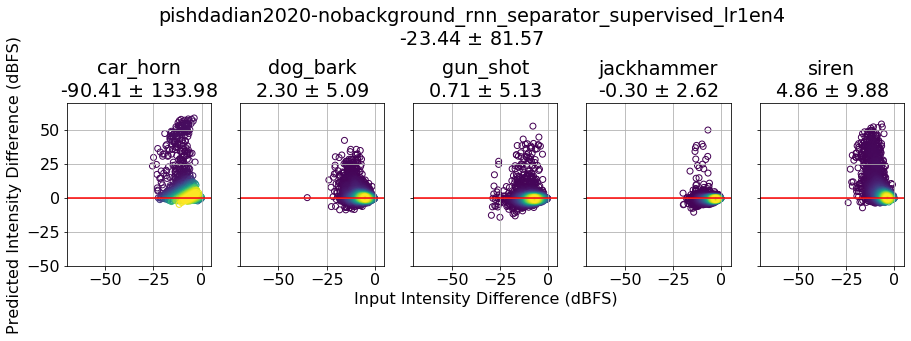

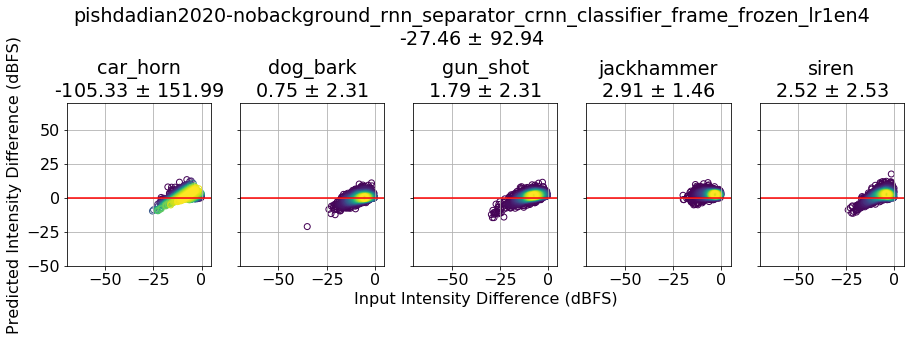

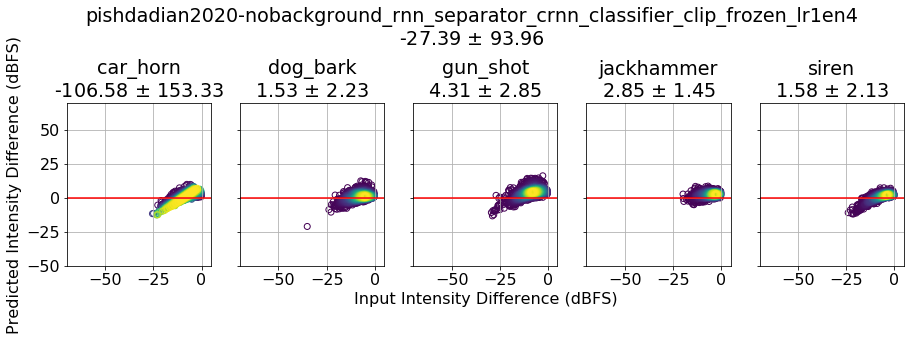

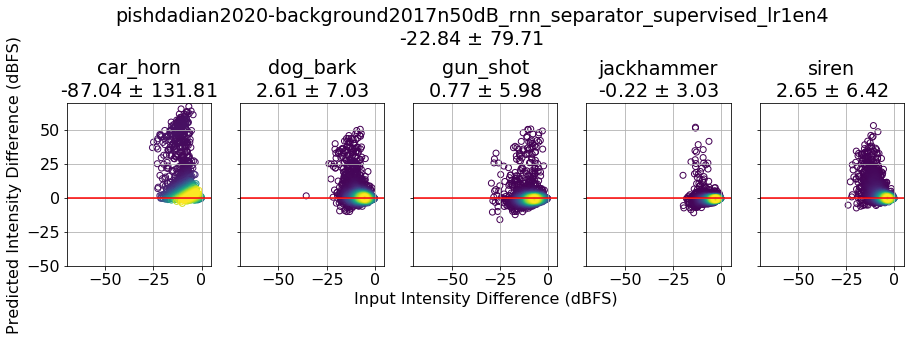

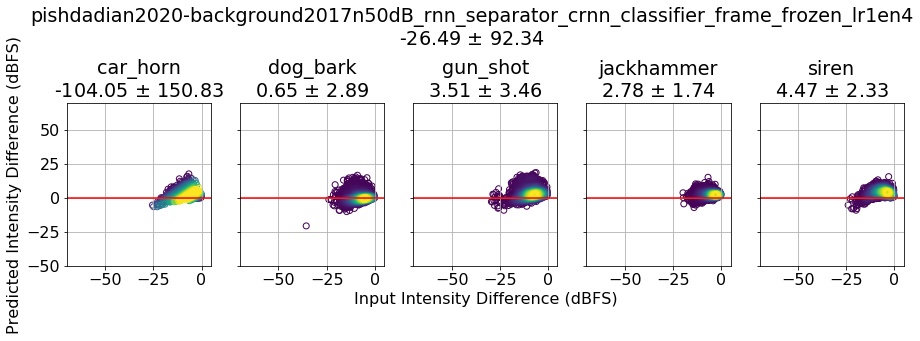

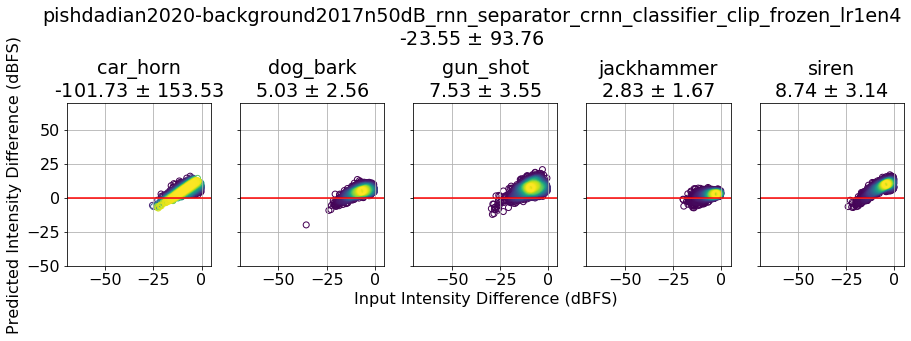

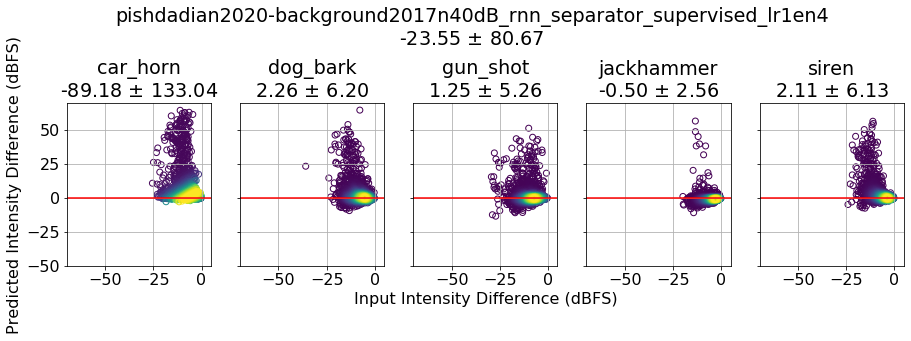

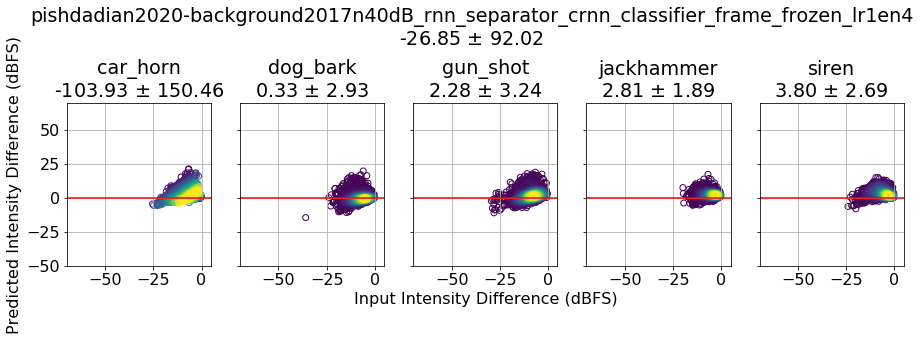

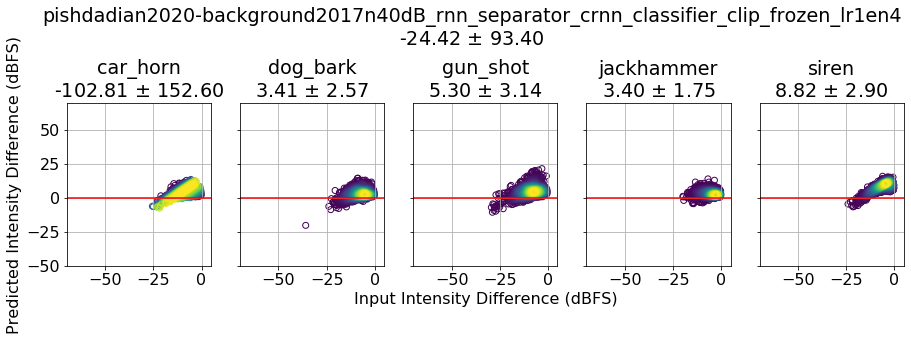

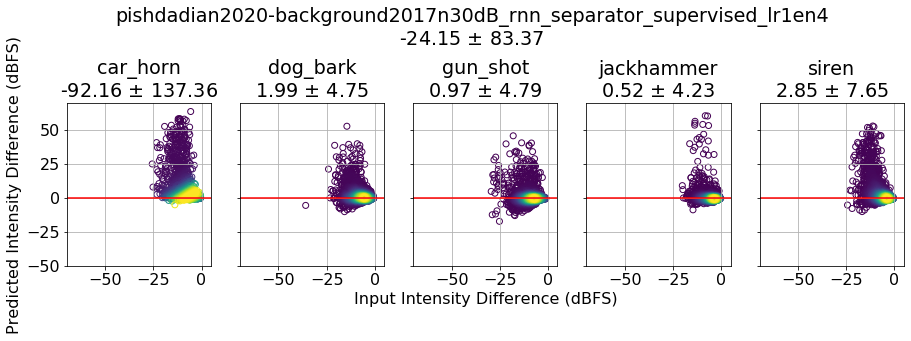

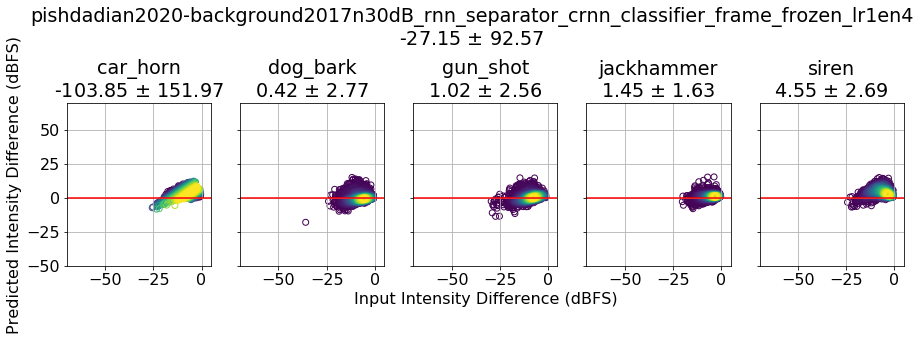

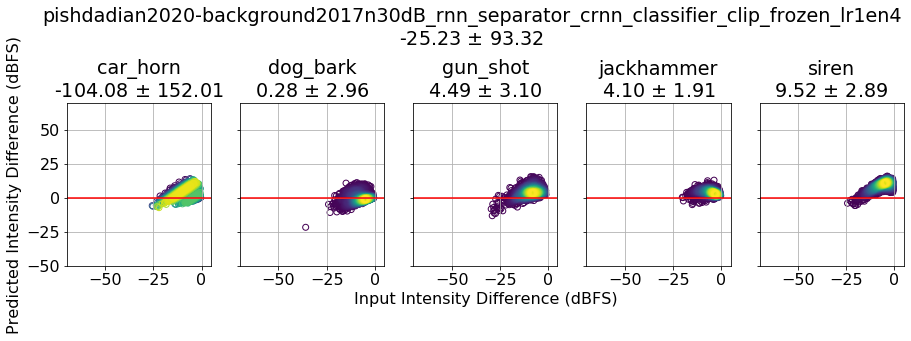

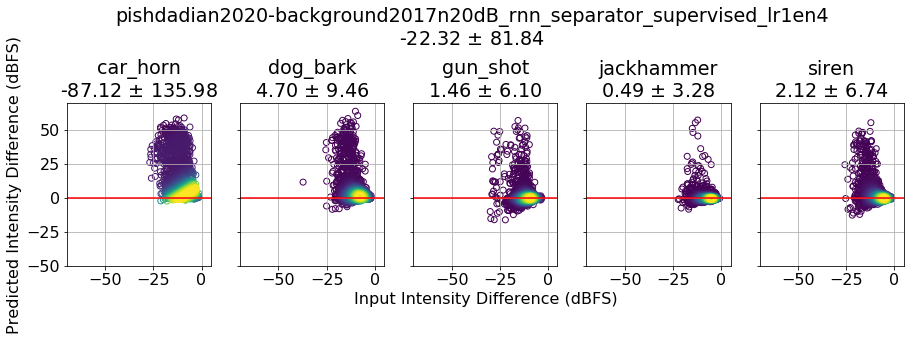

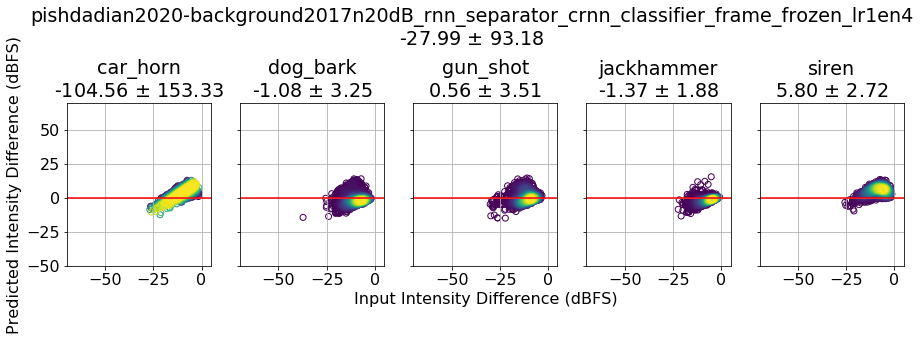

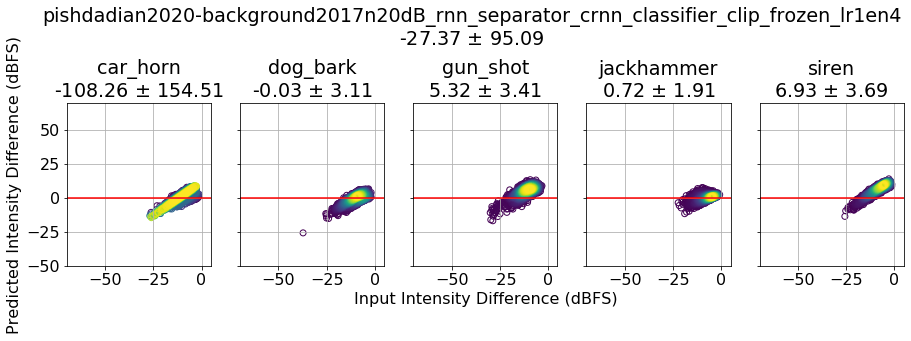

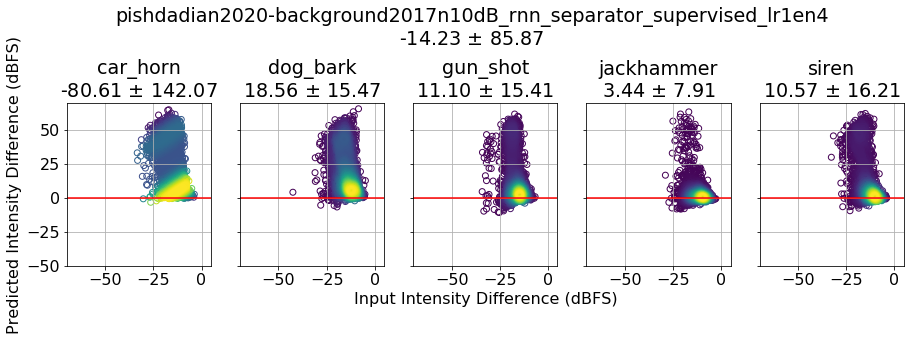

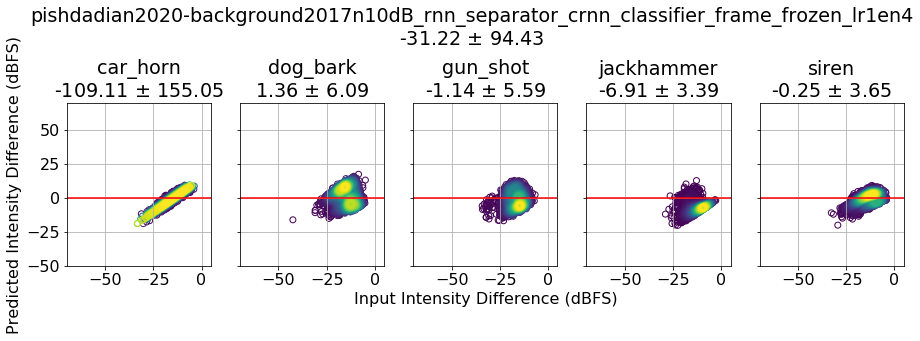

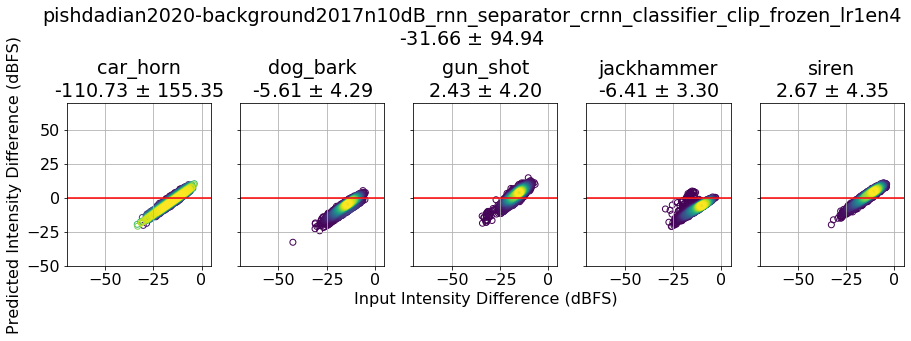

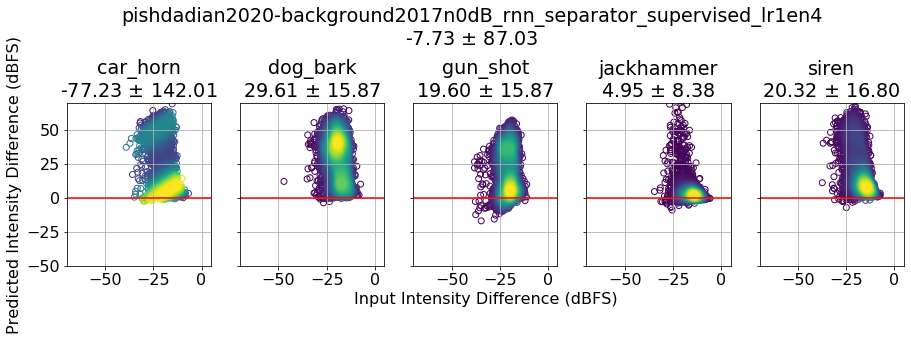

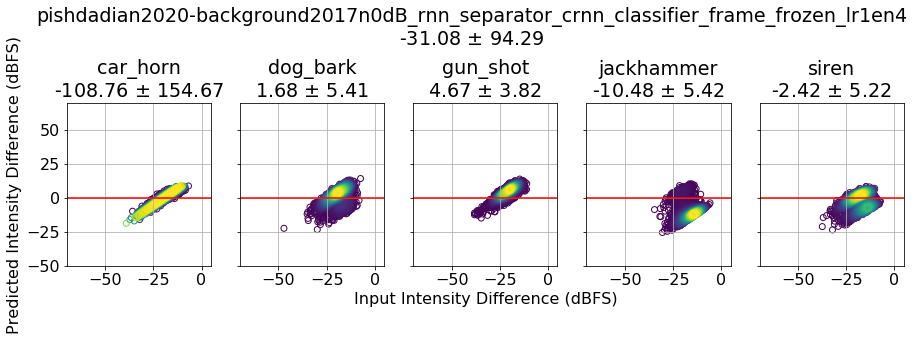

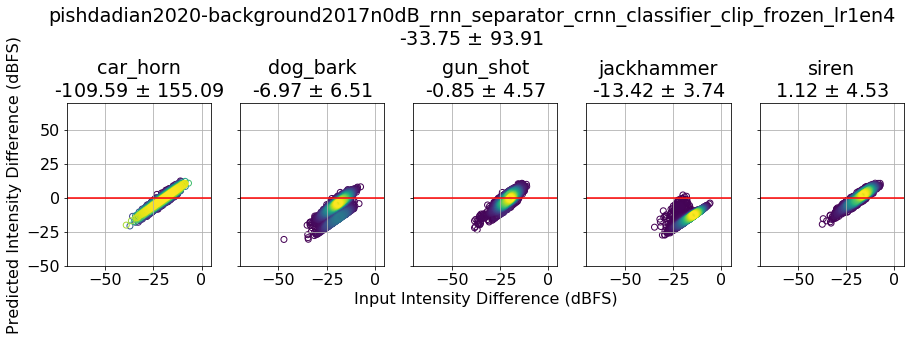

In [23]:
for exp_name in model_names:
    separator_dir = os.path.join(models_dir, exp_name)
    sep_config_path = os.path.join(separator_dir, 'config.json')
    if 'supervised' in exp_name:
        sep_res_path = os.path.join(separator_dir, 'fully_supervised_separation_results_earlystopping_test.csv')
    else:
        sep_res_path = os.path.join(separator_dir, 'separation_results_earlystopping_test.csv')

    if not os.path.exists(sep_config_path):
        continue
        
    if "margin" in exp_name:
        continue
        
    with open(sep_config_path, 'r') as f:
        sep_config = json.load(f)
        
#     if 'merl' not in sep_config['root_data_dir']:
#         continue

    #label_mode = sep_config['training']['label_mode']
    sep_df = pd.read_csv(sep_res_path)
    labels = [x.replace('_input_sisdr', '') for x in sep_df.keys() if x.endswith('_input_sisdr')]
    num_labels = len(labels)

    fig, axes = plt.subplots(ncols=len(labels), figsize=(15, 3), sharey=True)
    plt.rcParams.update({'font.size': 16})

    total_dbfs_arr = []
    label_dbfs = []

    num_sources = None
    for idx, label in enumerate(labels):
        if num_sources is None:
            num_sources = sep_df[label + '_presence_gt'].to_numpy()
        else:
            num_sources += sep_df[label + '_presence_gt'].to_numpy()
    multi_source_mask = (num_sources > 1).astype(bool)
    
    for idx, label in enumerate(labels):
        mask = sep_df[label + '_presence_gt'].to_numpy().astype(bool)
        mask = np.logical_and(mask, multi_source_mask)

        mixture_dbfs = sep_df['mixture_dbfs'].to_numpy()[mask]
        true_label_dbfs = sep_df['isolated_' + label + '_dbfs'].to_numpy()[mask]
        recon_label_dbfs = sep_df['reconstructed_' + label + '_dbfs'].to_numpy()[mask]
        input_dbfs_diff = true_label_dbfs - mixture_dbfs
        recon_dbfs_diff = true_label_dbfs - recon_label_dbfs
        
        ax = axes[idx]
        ax.set_title("{}\n{:.2f} $\pm$ {:.2f}".format(label, np.mean(recon_dbfs_diff), np.std(recon_dbfs_diff)))
        if idx == 0:
            ax.set_ylabel('Predicted Intensity Difference (dBFS)')
        if idx == (len(labels) // 2):
            ax.set_xlabel('Input Intensity Difference (dBFS)')
            
        xy = np.vstack([input_dbfs_diff, recon_dbfs_diff])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        sorted_idxs = z.argsort()
        input_dbfs_diff, recon_dbfs_diff, z = input_dbfs_diff[sorted_idxs], recon_dbfs_diff[sorted_idxs], z[sorted_idxs]
        norm = Normalize(vmin=z.min(), vmax=z.max())
        my_cmap = matplotlib.cm.get_cmap()
        color_list = [my_cmap(norm(c)) for c in z]
        
        ax.scatter(input_dbfs_diff, recon_dbfs_diff, edgecolors=color_list, facecolors='none')
        ax.set_ylim([-50, 70])
        ax.set_xlim([-70, 5])
        ax.set_facecolor('white')
        ax.axhline(y=0, color='red')
        ax.grid()
        fig.patch.set_facecolor('white')

        total_dbfs_arr.append(recon_dbfs_diff)

    total_dbfs_arr = np.concatenate(total_dbfs_arr)

    fig.suptitle("{}\n{:.2f} $\pm$ {:.2f}".format(exp_name, np.mean(total_dbfs_arr), np.std(total_dbfs_arr)),
                 y=1.325)

In [104]:
overall_sisdr_dict = {}
overall_sisir_dict = {}
overall_sisar_dict = {}
overall_minsdrsdsdr_dict = {}
overall_dbfs_dict = {}

class_sisdr_dict = {}
class_sisir_dict = {}
class_sisar_dict = {}
class_minsdrsdsdr_dict = {}
class_dbfs_dict = {}

for exp_name in model_names:
    if "margin" in exp_name:
        continue
    model_type = exp_name[exp_name.index('_') + 1:]
    background_type = exp_name.split('_')[0].split('-')[1]
    
    if model_type not in overall_sisdr_dict:
        class_sisdr_dict[model_type] = {}
        class_sisir_dict[model_type] = {}
        class_sisar_dict[model_type] = {}
        class_minsdrsisdr_dict[model_type] = {}
        class_dbfs_dict[model_type] = {}
    
    class_sisdr_dict[model_type][background_type] = {}
    class_sisir_dict[model_type][background_type] = {}
    class_sisar_dict[model_type][background_type] = {}
    class_minsdrsisdr_dict[model_type][background_type] = {}
    class_dbfs_dict[model_type][background_type] = {}
    
    separator_dir = os.path.join(models_dir, exp_name)
    sep_config_path = os.path.join(separator_dir, 'config.json')
    if 'supervised' in exp_name:
        sep_res_path = os.path.join(separator_dir, 'fully_supervised_separation_results_earlystopping_test.csv')
    else:
        sep_res_path = os.path.join(separator_dir, 'separation_results_earlystopping_test.csv')

    if not os.path.exists(sep_config_path):
        continue
        
    if not os.path.exists(sep_res_path):
        print("Missing: {}".format(sep_res_path))
        continue
        
    with open(sep_config_path, 'r') as f:
        sep_config = json.load(f)

    sep_df = pd.read_csv(sep_res_path)
    labels = [x.replace('_input_sisdr', '') for x in sep_df.keys() if x.endswith('_input_sisdr')]
    num_labels = len(labels)

    total_sisdr_arr = []
    total_sisir_arr = []
    total_sisar_arr = []
    total_minsdrsdsdr_arr = []
    total_dbfs_arr = []    

    num_sources = None
    for idx, label in enumerate(labels):
        if num_sources is None:
            num_sources = sep_df[label + '_presence_gt'].to_numpy()
        else:
            num_sources += sep_df[label + '_presence_gt'].to_numpy()
    multi_source_mask = (num_sources > 1).astype(bool)

    for idx, label in enumerate(labels):
        mask = sep_df[label + '_presence_gt'].to_numpy().astype(bool)
        mask = np.logical_and(mask, multi_source_mask)
        
        recon_sisdr = sep_df[label + '_recon_sisdr'].to_numpy()[mask]
        recon_sisir = sep_df[label + '_recon_sisir'].to_numpy()[mask]
        recon_sisar = sep_df[label + '_recon_sisar'].to_numpy()[mask]

        recon_sdsdr = sep_df[label + '_recon_sdsdr'].to_numpy()[mask]
        recon_sdr = sep_df[label + '_recon_sdr'].to_numpy()[mask]
        recon_minsdrsdsdr = np.minimum(recon_sdr, recon_sdsdr)
        
        true_label_dbfs = sep_df['isolated_' + label + '_dbfs'].to_numpy()[mask]
        recon_label_dbfs = sep_df['reconstructed_' + label + '_dbfs'].to_numpy()[mask]
        recon_dbfs_diff = true_label_dbfs - recon_label_dbfs
        
        total_sisdr_arr.append(recon_sisdr)
        total_sisir_arr.append(recon_sisir)
        total_sisar_arr.append(recon_sisar)
        total_minsdrsisdr_arr.append(recon_minsdrsisdr)
        total_dbfs_arr.append(recon_dbfs_diff)
        
        class_sisdr_dict[model_type][background_type][label] = recon_sisdr
        class_sisir_dict[model_type][background_type][label] = recon_sisir
        class_sisar_dict[model_type][background_type][label] = recon_sisar
        class_minsdrsisdr_dict[model_type][background_type][label] = recon_minsdrsisdr
        class_dbfs_dict[model_type][background_type][label] = recon_dbfs_diff
        
    total_sisdr_arr = np.concatenate(total_sisdr_arr)
    total_sisir_arr = np.concatenate(total_sisir_arr)
    total_sisar_arr = np.concatenate(total_sisar_arr)
    total_minsdrsisdr_arr = np.concatenate(total_minsdrsisdr_arr)
    total_dbfs_arr = np.concatenate(total_dbfs_arr)
    
    overall_sisdr_dict[model_type][background_type] = total_sisdr_arr
    overall_sisir_dict[model_type][background_type] = total_sisir_arr
    overall_sisar_dict[model_type][background_type] = total_sisar_arr
    overall_minsdrsisdr_dict[model_type][background_type] = total_minsdrsisdr_arr
    overall_dbfs_dict[model_type][background_type] = total_dbfs_arr 

In [105]:
from functools import reduce
import matplotlib.patches as mpatches

In [106]:
import seaborn as sns

In [107]:
background_keys = sorted(list(reduce(lambda x, y: x | y, [set(x.keys()) for x in overall_sisdr_dict.values()], set())), reverse=True)
background_labels = ['None' if x == "nobackground" else "-" + x[x.rindex('n')+1:] for x in background_keys]

In [108]:
num_model_types = len(impro_sisdr_dict.keys())

In [ ]:
def plot_overall_source_sep_violins(overall_metric_dict, ylabel, title, ylim=None)
    fig = plt.figure(figsize=(15, 5))
    ax = plt.gca()
    ax.grid(zorder=0)

    legend_labels = []
    for model_idx, (model_type, model_metric_dict) in enumerate(overall_metric_dict.items()):
        metric_list = [model_metric_dict[x] for x in background_keys]
        x = np.arange(len(background_keys)) + (2 * model_idx / num_model_types - 1) * 0.4
        name = model_type.replace("rnn_separator_", "").replace("crnn_classifier_", "").replace("_lr1en4", "").replace("_frozen", "").replace("_", " ")

        violin_handle = ax.violinplot(metric_list, positions=x, widths=0.3, showmedians=True)
        color = violin_handle["bodies"][0].get_facecolor().flatten()
        legend_labels.append((mpatches.Patch(color=color), name))

        ax.set_xticks(np.arange(len(background_keys)))
        ax.set_xticklabels(background_labels)

    ax.legend(*zip(*legend_labels), loc=[1.05, 0.4])
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Background Loudness (LUFS)')
    ax.set_title(title)
    fig.patch.set_facecolor('white')

In [ ]:
plot_overall_source_sep_violins(overall_sisdr_dict, "Output SI-SDR", "Model performance with varying background presence", ylim=[-60, 30])

In [ ]:
plot_overall_source_sep_violins(overall_dbfs_dict, "dBFS Error", "Model performance with varying background presence", ylim=[-50, 70])

In [ ]:
plot_overall_source_sep_violins(overall_minsdrsisdr_dict, "min(SDR, SI-SDR)", "Model performance with varying background presence", ylim=[-50, 70])

In [ ]:
def plot_class_source_sep_violins(class_metric_dict, ylabel, title, ylim=None)
    fig, axes = plt.subplots(ncols=len(labels), figsize=(15, 5 * len(labels)))
    
    for label_idx, label in enumerate(labels):
        ax = axes[label_idx]
        ax.grid(zorder=0)

        legend_labels = []
        for model_idx, (model_type, model_metric_dict) in enumerate(class_metric_dict.items()):
            metric_list = [model_metric_dict[x][label] for x in background_keys]
            x = np.arange(len(background_keys)) + (2 * model_idx / num_model_types - 1) * 0.4
            name = model_type.replace("rnn_separator_", "").replace("crnn_classifier_", "").replace("_lr1en4", "").replace("_frozen", "").replace("_", " ")

            violin_handle = ax.violinplot(metric_list, positions=x, widths=0.3, showmedians=True)
            color = violin_handle["bodies"][0].get_facecolor().flatten()
            legend_labels.append((mpatches.Patch(color=color), name))

            ax.set_xticks(np.arange(len(background_keys)))
            ax.set_xticklabels(background_labels)

        ax.legend(*zip(*legend_labels), loc=[1.05, 0.4])
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Background Loudness (LUFS)')
        ax.set_title(label)
    fig.suptitle(title)
    fig.patch.set_facecolor('white')

In [ ]:
plot_overall_source_sep_violins(class_sisdr_dict, "Output SI-SDR", "Model performance with varying background presence", ylim=[-60, 30])

In [ ]:
plot_overall_source_sep_violins(class_dbfs_dict, "dBFS Error", "Model performance with varying background presence", ylim=[-50, 70])

In [ ]:
plot_overall_source_sep_violins(class_minsdrsisdr_dict, "min(SDR, SI-SDR)", "Model performance with varying background presence", ylim=[-50, 70])

In [ ]:
def max_polyphony(frame_labels):
    '''
    Given an annotation of sound events, compute the maximum polyphony, i.e.
    the maximum number of simultaneous events at any given point in time. Only
    foreground events are taken into consideration for computing the polyphony.
    Parameters
    '''

    # ([batch], time, label)
    # Get maximum number of simultaneously occurring events
    polyphony = frame_labels.sum(dim=-1).max(dim=-1)[0]
    return polyphony


def gini_polyphony(frame_labels):
    '''
    Compute the gini coefficient of the annotation's polyphony time series.
    Useful as an estimate of the polyphony "flatness" or entropy. The
    coefficient is in the range [0,1] and roughly inverse to entropy: a
    distribution that's close to uniform will have a low gini coefficient
    (high entropy), vice versa.
    https://en.wikipedia.org/wiki/Gini_coefficient
    '''

    # Sample the polyphony using the specified hop size
    values = frame_labels.sum(dim=-1)

    # Compute gini as per:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    values += 1e-6  # all values must be positive
    values = torch.sort(values, dim=-1)[0]  # sort values
    n = values.shape[-1]
    i = torch.arange(n) + 1
    gini = torch.sum((2*i - n - 1) * values, dim=-1) / (n * torch.sum(values, dim=-1))
    return (1 - gini)

In [ ]:
max_polyphony(train_dataset.get_labels(0)['frame_labels']).item()

In [ ]:
test_dataset.files.index(sep_df['filenames'][3])

In [ ]:
input_transform = get_data_transforms(sep_config)
test_dataset = CDSDDataset(sep_config['root_data_dir'],
                           subset='test',
                           transform=input_transform,
                           load_separation_data=True)

In [ ]:
train_dataset = CDSDDataset(sep_config['root_data_dir'],
                            subset='train',
                            transform=input_transform,
                            load_separation_data=True)

In [ ]:
sep_config['root_data_dir']

In [ ]:
sep_config_path

In [ ]:
for exp_name in model_names:
    separator_dir = os.path.join(models_dir, exp_name)
    sep_config_path = os.path.join(separator_dir, 'config.json')
    if 'supervised' in exp_name:
        sep_res_path = os.path.join(separator_dir, 'fully_supervised_separation_results_earlystopping_test.csv')
    else:
        sep_res_path = os.path.join(separator_dir, 'separation_results_earlystopping_test.csv')

    if not os.path.exists(sep_config_path):
        continue
        
    if not os.path.exists(sep_res_path):
        print("Missing: {}".format(sep_res_path))
        continue
        
    with open(sep_config_path, 'r') as f:
        sep_config = json.load(f)
        
    input_transform = get_data_transforms(sep_config)
    test_dataset = CDSDDataset(sep_config['root_data_dir'],
                               subset='test',
                               transform=input_transform,
                               load_separation_data=False)
        
    sep_df = pd.read_csv(sep_res_path)
    labels = [x.replace('_input_sisdr', '') for x in sep_df.keys() if x.endswith('_input_sisdr')]
    num_labels = len(labels)
    
    if sep_df['filenames'][0] not in test_dataset.files:
        continue

    fig, axes = plt.subplots(ncols=len(labels), figsize=(15, 3), sharey=True)
    plt.rcParams.update({'font.size': 16})

    total_sisdr_arr = []
    label_sisdr = []
    
    num_sources = None
    for idx, label in enumerate(labels):
        if num_sources is None:
            num_sources = sep_df[label + '_presence_gt'].to_numpy()
        else:
            num_sources += sep_df[label + '_presence_gt'].to_numpy()
    multi_source_mask = (num_sources > 1).astype(bool)
    max_poly_arr = np.array([max_polyphony(test_dataset.get_labels(test_dataset.files.index(x))['frame_labels']).item() for x in sep_df['filenames']])

    for idx, label in enumerate(labels):
        mask = sep_df[label + '_presence_gt'].to_numpy().astype(bool)
        mask = np.logical_and(mask, multi_source_mask)
        impro_sisdr = np.nan_to_num(sep_df[label + '_sisdr_improvement'].to_numpy())[mask]
        max_poly = max_poly_arr[mask]

        ax = axes[idx]
        ax.set_title("{}\n{:.2f} $\pm$ {:.2f}".format(label, np.mean(impro_sisdr), np.std(impro_sisdr)))
        if idx == 0:
            ax.set_ylabel('SI-SDR Improvement (dB)')
        if idx == (len(labels) // 2):
            ax.set_xlabel('Max polyphony')
            
        xy = np.vstack([max_poly, impro_sisdr])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        sorted_idxs = z.argsort()
        max_poly, impro_sisdr, z = max_poly[sorted_idxs], impro_sisdr[sorted_idxs], z[sorted_idxs]
        norm = Normalize(vmin=z.min(), vmax=z.max())
        my_cmap = matplotlib.cm.get_cmap()
        color_list = [my_cmap(norm(c)) for c in z]
        
        ax.scatter(max_poly, impro_sisdr, edgecolors=color_list, facecolors='none')
        ax.set_ylim([-30, 70])
        ax.set_xlim([0, 6])
        ax.set_facecolor('white')
        ax.axhline(y=0, color='red')
        ax.grid()
        fig.patch.set_facecolor('white')

        total_sisdr_arr.append(impro_sisdr)

    total_sisdr_arr = np.concatenate(total_sisdr_arr)

    fig.suptitle("{}\n{:.2f} $\pm$ {:.2f}".format(exp_name, np.mean(total_sisdr_arr), np.std(total_sisdr_arr)),
                 y=1.325)

In [ ]:
for exp_name in model_names:
    separator_dir = os.path.join(models_dir, exp_name)
    sep_config_path = os.path.join(separator_dir, 'config.json')
    if 'supervised' in exp_name:
        sep_res_path = os.path.join(separator_dir, 'fully_supervised_separation_results_earlystopping_test.csv')
    else:
        sep_res_path = os.path.join(separator_dir, 'separation_results_earlystopping_test.csv')

    if not os.path.exists(sep_config_path):
        continue
        
    if not os.path.exists(sep_res_path):
        print("Missing: {}".format(sep_res_path))
        continue
        
    with open(sep_config_path, 'r') as f:
        sep_config = json.load(f)
        
    input_transform = get_data_transforms(sep_config)
    test_dataset = CDSDDataset(sep_config['root_data_dir'],
                               subset='test',
                               transform=input_transform,
                               load_separation_data=False)
        
    sep_df = pd.read_csv(sep_res_path)
    labels = [x.replace('_input_sisdr', '') for x in sep_df.keys() if x.endswith('_input_sisdr')]
    num_labels = len(labels)
    
    if sep_df['filenames'][0] not in test_dataset.files:
        continue

    fig, axes = plt.subplots(ncols=len(labels), figsize=(15, 3), sharey=True)
    plt.rcParams.update({'font.size': 16})

    total_sisdr_arr = []
    label_sisdr = []
    
    num_sources = None
    for idx, label in enumerate(labels):
        if num_sources is None:
            num_sources = sep_df[label + '_presence_gt'].to_numpy()
        else:
            num_sources += sep_df[label + '_presence_gt'].to_numpy()
    multi_source_mask = (num_sources > 1).astype(bool)
    gini_poly_arr = np.array([gini_polyphony(test_dataset.get_labels(test_dataset.files.index(x))['frame_labels']).item() for x in sep_df['filenames']])

    for idx, label in enumerate(labels):
        mask = sep_df[label + '_presence_gt'].to_numpy().astype(bool)
        mask = np.logical_and(mask, multi_source_mask)
        impro_sisdr = np.nan_to_num(sep_df[label + '_sisdr_improvement'].to_numpy())[mask]
        gini_poly = gini_poly_arr[mask]

        ax = axes[idx]
        ax.set_title("{}\n{:.2f} $\pm$ {:.2f}".format(label, np.mean(impro_sisdr), np.std(impro_sisdr)))
        if idx == 0:
            ax.set_ylabel('SI-SDR Improvement (dB)')
        if idx == (len(labels) // 2):
            ax.set_xlabel('Gini polyphony')
            
        xy = np.vstack([gini_poly, impro_sisdr])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        sorted_idxs = z.argsort()
        gini_poly, impro_sisdr, z = gini_poly[sorted_idxs], impro_sisdr[sorted_idxs], z[sorted_idxs]
        norm = Normalize(vmin=z.min(), vmax=z.max())
        my_cmap = matplotlib.cm.get_cmap()
        color_list = [my_cmap(norm(c)) for c in z]
        
        ax.scatter(gini_poly, impro_sisdr, edgecolors=color_list, facecolors='none')
        ax.set_ylim([-30, 70])
        ax.set_xlim([0, 1])
        ax.set_facecolor('white')
        ax.axhline(y=0, color='red')
        ax.grid()
        fig.patch.set_facecolor('white')

        total_sisdr_arr.append(impro_sisdr)

    total_sisdr_arr = np.concatenate(total_sisdr_arr)

    fig.suptitle("{}\n{:.2f} $\pm$ {:.2f}".format(exp_name, np.mean(total_sisdr_arr), np.std(total_sisdr_arr)),
                 y=1.325)

In [11]:
train_files = []
valid_files = []
root_dir = sep_config['root_data_dir']
for subset in ('train', 'valid'):
    data_dir = os.path.join(root_dir, subset)
    if not os.path.isdir(data_dir):
        warnings.warn('Could not find subset {} in {}. Skipping.'.format(subset, root_dir))
        continue

    for fname in os.listdir(data_dir):
        # Only look at audio files
        if not fname.endswith('.wav'):
            continue
        name = os.path.splitext(fname)[0]

        # Make sure there's a corresponding JAMS file
        jams_path = os.path.join(root_dir, subset, name + '.jams')
        if not os.path.exists(jams_path):
            raise ValueError('Missing JAMS file for {} in {}'.format(fname, self.data_dir))

        # If we are loading the separation data, only include the files
        # that have separated sources
        event_dir = os.path.join(data_dir, name + "_events")
        if not os.path.isdir(event_dir):
            continue

        if subset == 'train':
            train_files.append(name)
        else:
            valid_files.append(name)

In [12]:
num_labels = 5
labels = ['car_horn', 'dog_bark', 'gun_shot', 'jackhammer', 'siren']

In [13]:
#separator_dir = '/scratch/jtc440/cdsd/models/pishdadian2020-background2017_rnn_separator_supervised_lr1en4'
separator_dir = '/scratch/jtc440/cdsd/models/pishdadian2020-nobackground_rnn_separator_crnn_classifier_frame_frozen_lr1en4'

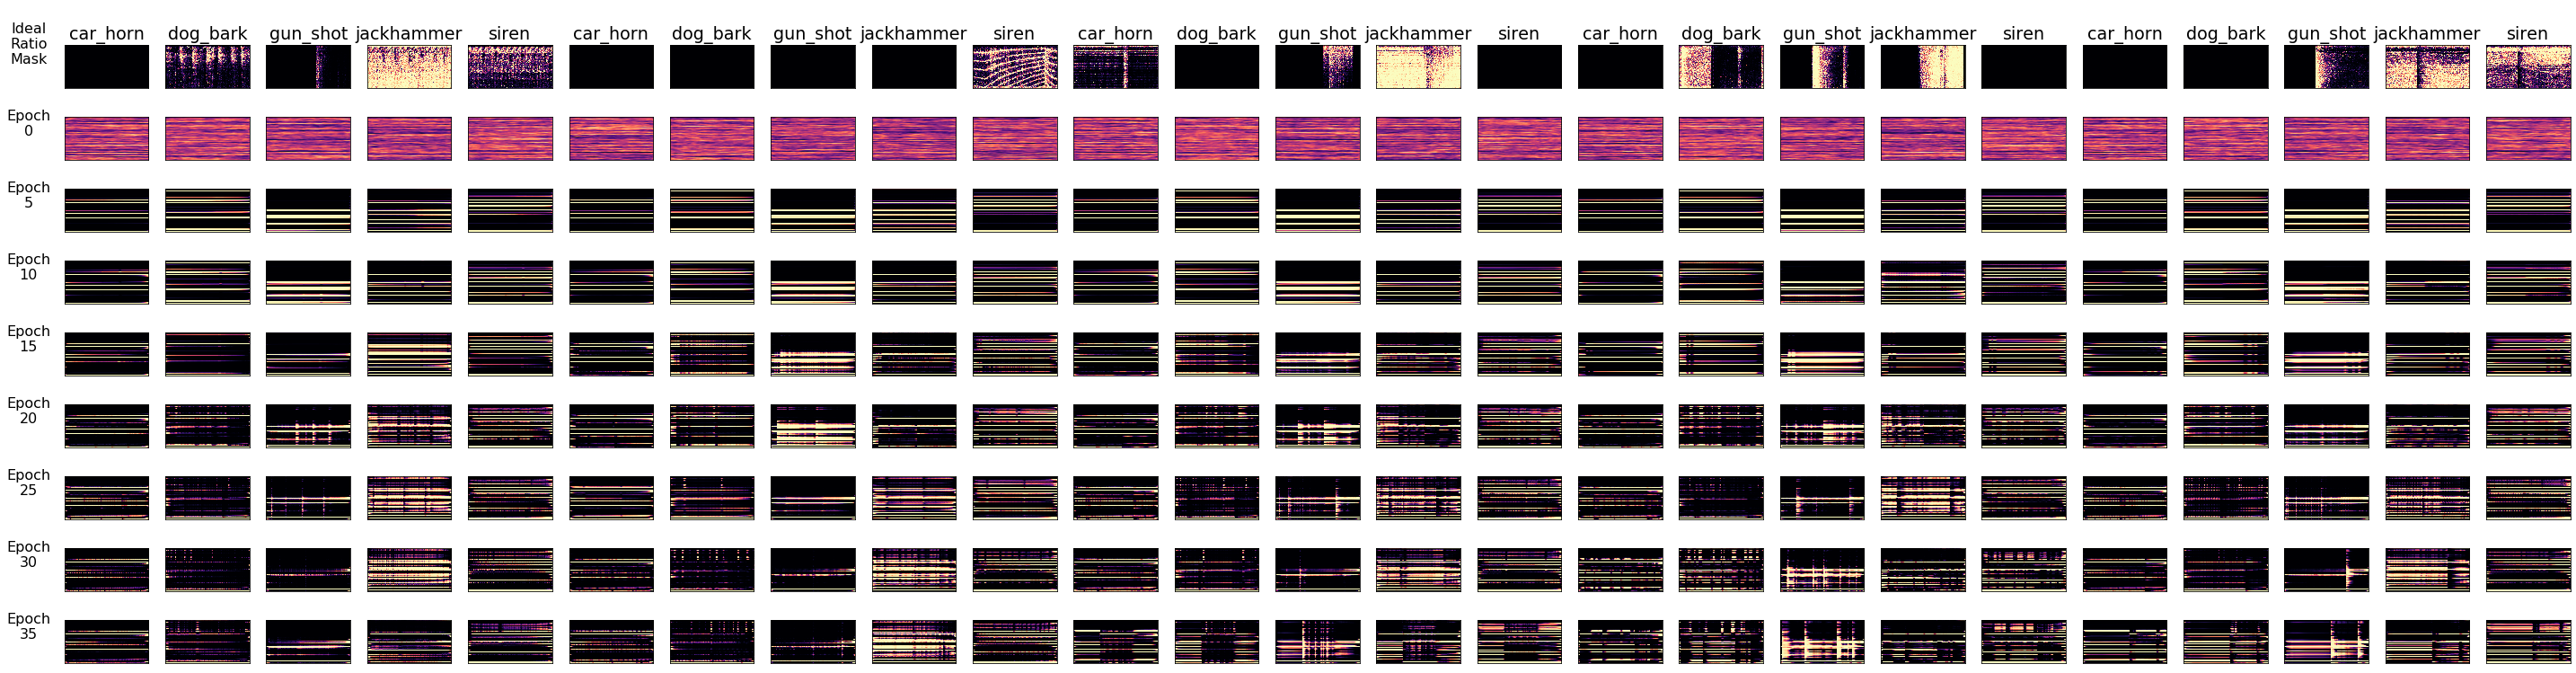

In [14]:
my_cmap = copy.copy(matplotlib.cm.get_cmap('magma')) # copy the default cmap
my_cmap.set_bad((0,0,0))

for max_epoch in range(0, 50, 5):
    mask_debug_path = os.path.join(separator_dir, 'mask_debug_{}.npz').format(max_epoch)
    if not os.path.exists(mask_debug_path):
        break

epoch_list = range(0, max_epoch, 5)


mask_debug_path = os.path.join(separator_dir, 'mask_debug_0.npz')
mask_debug_data = np.load(mask_debug_path)
num_debug_examples = mask_debug_data['train_idxs'].shape[0]


fig, axes = plt.subplots(nrows=len(epoch_list)+1, ncols=num_debug_examples*num_labels, figsize=(50, max_epoch//5 + 5), sharey=True)

vmin = 0.0
vmax = 1.0

# mask_debug_path = os.path.join(separator_dir, 'mask_debug_0.npz')
# mask_debug_data = np.load(mask_debug_path)
# debug_train_idxs = mask_debug_data['train_idxs']
# for idx, ex_idx in enumerate(debug_train_idxs):
#     ex = train_dataset[ex_idx]
#     vmax = max(vmax, ex['audio_data'].numpy().max())
#     for label in labels:
#         vmax = max(vmax, ex[label + '_transformed'].numpy().max())
        
        
for epoch_idx, debug_epoch in enumerate(epoch_list):
    mask_debug_path = os.path.join(separator_dir, 'mask_debug_{}.npz').format(debug_epoch)
    if not os.path.exists(mask_debug_path):
        continue
    mask_debug_data = np.load(mask_debug_path)
    debug_train_masks = mask_debug_data['train_masks'].squeeze(axis=1)
    debug_train_idxs = mask_debug_data['train_idxs']
    debug_valid_masks = mask_debug_data['valid_masks'].squeeze(axis=1)
    debug_valid_idxs = mask_debug_data['valid_idxs']
    

    for label_idx, label in enumerate(labels):
        for idx, ex_idx in enumerate(debug_train_idxs):
            col_idx = idx * num_labels + label_idx
            #mix_spec = train_dataset[ex_idx]['audio_data'].numpy().squeeze()
            ax = axes[epoch_idx+1, col_idx]
            ax.imshow(debug_train_masks[idx, ..., label_idx], cmap='magma', vmin=vmin, vmax=vmax)
            #ax.imshow(debug_train_masks[idx, ..., label_idx] * mix_spec, cmap=my_cmap, norm=LogNorm())
            ax.set_xticks([]) 
            ax.set_yticks([]) 

            if col_idx == 0:
                ax.set_ylabel('\nEpoch\n{}'.format(debug_epoch), rotation=0, labelpad=40)

for label_idx, label in enumerate(labels):
    for idx, ex_idx in enumerate(debug_train_idxs):
        col_idx = idx * num_labels + label_idx
        #mask_path = os.path.join(separator_dir,
        #                         "reconstructed_masks", "{}_{}_recon.npz".format(train_files[ex_idx], label))
        #ideal_mask = np.nan_to_num(np.load(mask_path)['ideal_mask'].squeeze())
        ex = train_dataset[ex_idx]
        ideal_mask = np.nan_to_num((ex[label + '_transformed'] / ex['audio_data']).numpy()).squeeze()
        ax = axes[0, col_idx]
        ax.imshow(ideal_mask, cmap='magma', vmin=vmin, vmax=vmax)
        #ax.imshow(train_dataset[ex_idx][label + '_transformed'].squeeze(), cmap=my_cmap, norm=LogNorm())
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        if col_idx == 0:
            ax.set_ylabel('\nIdeal\nRatio\nMask', rotation=0, labelpad=40)
        ax.set_title(label)
        
#         ex = valid_dataset[ex_idx]
#         mixture_spec = ex['audio_data'].squeeze()
#         source_spec = ex[label + '_transformed'].squeeze()
#         ideal_mask = np.nan_to_num(source_spec / mixture_spec)

#plt.tight_layout()
None


In [77]:
y_gt = []
y_pred = []
y_pred_thresh = []
class_ap_score = {}
class_acc_score = {}

if label_mode == 'clip':
    for label in labels:
        y_gt_cls = np.array(sep_df[label + '_presence_gt'].to_list(), dtype=int)
        y_pred_cls = sep_df['mixture_pred_' + label].to_list()
        y_gt.append(y_gt_cls)
        y_pred.append(y_pred_cls)
        y_pred_cls_thresh = (np.array(y_pred_cls) >= 0.5).astype(int)
        class_acc_score[label] = (y_gt_cls == y_pred_cls_thresh).astype(float).mean()
        class_ap_score[label] = average_precision_score(y_gt_cls, y_pred_cls)
    y_gt = np.array(y_gt).T
    y_pred = np.array(y_pred).T
    y_pred_thresh = np.array(y_pred_thresh).T
else:
    for label in labels:
        y_gt_cls = np.array([eval(x) for x in sep_df[label + '_presence_frame_gt'].to_list()], dtype=int)
        y_pred_cls = [eval(x) for x in sep_df['mixture_pred_' + label].tolist()]
        y_gt.append(y_gt_cls)
        y_pred.append(y_pred_cls)
        y_pred_cls_thresh = (np.array(y_pred_cls) >= 0.5).astype(int)
        class_acc_score[label] = (y_gt_cls == y_pred_cls_thresh).astype(float).mean()
        class_ap_score[label] = average_precision_score(y_gt_cls, y_pred_cls)
    y_gt = np.array(y_gt).T
    y_pred = np.array(y_pred).T
    y_pred_thresh = np.array(y_pred_thresh).T
    

In [78]:
for label in labels:
    gt_key = label + "_presence_gt"
    print("{} clip-level ratio: {}".format(label, sep_df[gt_key].mean()))

car_horn clip-level ratio: 0.6402
dog_bark clip-level ratio: 0.6372
gun_shot clip-level ratio: 0.641
jackhammer clip-level ratio: 0.64
siren clip-level ratio: 0.635


In [ ]:
cm = []
cooccurrence = []
thresholds = {label: 0.5 for label in labels}
for label_idx, label in enumerate(labels):
    pos_gt_idxs = y_gt[:, label_idx].nonzero()[0]
    cooccurrence.append(y_gt[pos_gt_idxs, :].mean(axis=0))
    
    fn_idxs = (y_pred[pos_gt_idxs, label_idx] < thresholds[label]).nonzero()[0]
    cm.append((y_pred[pos_gt_idxs, :][fn_idxs, :] > thresholds[label]).mean(axis=0))
cm = np.array(cm)
cooccurrence = np.array(cooccurrence)

In [ ]:
cm_min = cm[cm != 0].min()

plt.imshow(cm, aspect=1, cmap='magma', vmin=cm_min * 0.8, vmax=1)
plt.colorbar()
plt.ylabel('Ground truth class\n(Predicted as negative)')
plt.xlabel('Predicted positive classes')
plt.title('Class confusion')
plt.xticks(range(len(labels)), labels=labels, rotation=45)
plt.yticks(range(len(labels)), labels=labels)

In [ ]:
plt.imshow(cooccurrence, aspect=1, cmap='magma', vmin=0, vmax=1)
plt.colorbar()
plt.title('Class co-occurrence')
plt.xticks(range(len(labels)), labels=labels, rotation=45)
plt.yticks(range(len(labels)), labels=labels)

Text(0.5, 1.1, 'Model activation distributions')

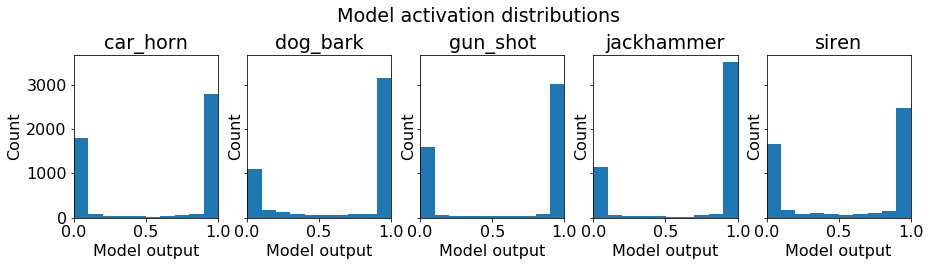

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(15, 3), sharey=True)
for idx, (label, y) in enumerate(zip(labels, y_pred.T)):
    ax = axes[idx]
    ax.hist(y)
    ax.set_title(label)
    ax.set_ylabel('Count')
    ax.set_xlabel('Model output')
    ax.set_xlim([0, 1.0])
    #plt.yscale('log')
fig.suptitle("Model activation distributions", y = 1.1)

In [24]:
class_acc_score

{'car_horn': 0.9563696,
 'dog_bark': 0.9043456,
 'gun_shot': 0.9036064,
 'jackhammer': 0.9178112,
 'siren': 0.9089072}

In [27]:
#average_precision_score(y_gt, y_pred, average='macro')

In [26]:
class_ap_score

{'car_horn': 0.9939091414008566,
 'dog_bark': 0.9731553430661394,
 'gun_shot': 0.9363888037188528,
 'jackhammer': 0.9913587396330666,
 'siren': 0.9861890933447094}